In [7]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

print(tf.test.is_gpu_available())




True


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [8]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


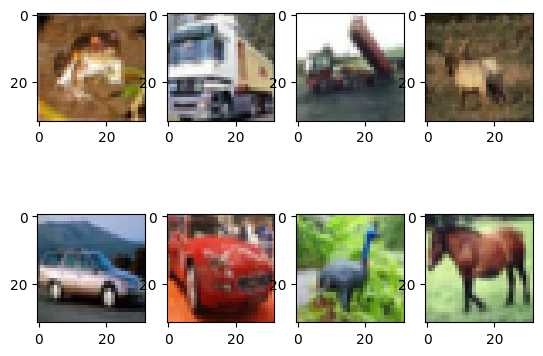

In [9]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [10]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [11]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [12]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [13]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.1, random_state=42)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    if os.path.exists('./model_I.h5'):
        models.load_model('./model_I.h5')

        image = np.expand_dims(image, axis=0)

        pred = model.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        model.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        history_I = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

        test_loss_I, test_acc_I = model.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_I}, Test Accuracy: {test_acc_I}")

        model.save('./model_I.h5')

        plt.plot(history_I.history['accuracy'])
        plt.plot(history_I.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history_I.history['loss'])
        plt.plot(history_I.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        image = np.expand_dims(image, axis=0)

        pred = model.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class

### 2.3. Model II

In [14]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.3, random_state=42)

    # 数据预处理
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # 创建数据增强生成器
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # 对训练集进行数据增强
    datagen.fit(X_train)

    model_II = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])


    if os.path.exists('./model_II.h5'):
        models.load_model('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        # model_II.compile(optimizer='adam',
        #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #                  metrics=['accuracy'])

        sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
        model_II.compile(optimizer=sgd_optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        history_II = model_II.fit(datagen.flow(X_train, y_train, batch_size=32),
                     epochs=200,
                     validation_data=(X_test, y_test))
        

        test_loss_II, test_acc_II = model_II.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_II}, Test Accuracy: {test_acc_II}")

        plt.plot(history_II.history['accuracy'])
        plt.plot(history_II.history['val_accuracy'])
        plt.title('Mode2 accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history_II.history['loss'])
        plt.plot(history_II.history['val_loss'])
        plt.title('Mode2 loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        model_II.save('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [15]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

Epoch 1/200
282/282 [==============================] - 4s 6ms/step - loss: 2.2983 - accuracy: 0.2648 - val_loss: 1.7196 - val_accuracy: 0.3650
Epoch 2/200
282/282 [==============================] - 1s 4ms/step - loss: 1.6799 - accuracy: 0.3849 - val_loss: 1.5451 - val_accuracy: 0.4270
Epoch 3/200
282/282 [==============================] - 1s 4ms/step - loss: 1.5165 - accuracy: 0.4484 - val_loss: 1.4393 - val_accuracy: 0.4950
Epoch 4/200
282/282 [==============================] - 1s 4ms/step - loss: 1.4105 - accuracy: 0.4970 - val_loss: 1.3962 - val_accuracy: 0.5170
Epoch 5/200
282/282 [==============================] - 1s 3ms/step - loss: 1.2799 - accuracy: 0.5436 - val_loss: 1.4439 - val_accuracy: 0.5020
Epoch 6/200
282/282 [==============================] - 1s 3ms/step - loss: 1.1999 - accuracy: 0.5728 - val_loss: 1.4289 - val_accuracy: 0.5040
Epoch 7/200
282/282 [==============================] - 1s 4ms/step - loss: 1.0884 - accuracy: 0.6127 - val_loss: 1.4951 - val_accuracy: 0.4940

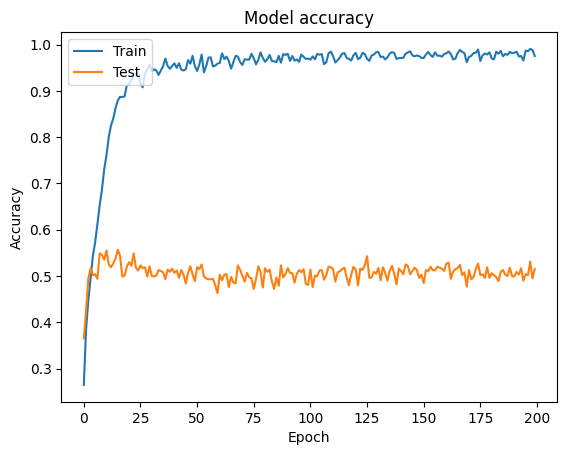

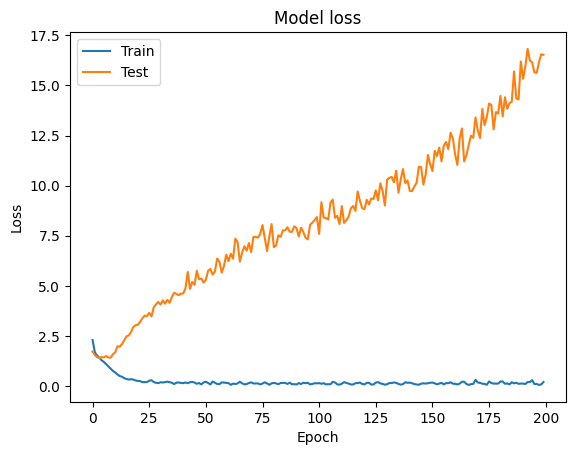

              precision    recall  f1-score   support

           0       0.12      0.14      0.13       102
           1       0.11      0.10      0.10       112
           2       0.13      0.14      0.13        99
           3       0.06      0.07      0.06        92
           4       0.10      0.10      0.10        99
           5       0.12      0.13      0.12        85
           6       0.09      0.08      0.09       107
           7       0.08      0.07      0.07       102
           8       0.07      0.07      0.07        99
           9       0.10      0.09      0.09       103

    accuracy                           0.10      1000
   macro avg       0.10      0.10      0.10      1000
weighted avg       0.10      0.10      0.10      1000



In [16]:
#model1-eval
n_test = 1000
test_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")[:1000]
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    # img_fn = f'../data/test_images/test{i+1:05d}.png'
    img_fn = f'../data/images/{i + 1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(model_I, test_labels, test_imgs)

Epoch 1/200


C:\Users\James\.conda\envs\py3.9\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


219/219 [==============================] - 4s 14ms/step - loss: 2.4173 - accuracy: 0.1659 - val_loss: 2.1897 - val_accuracy: 0.1767
Epoch 2/200
219/219 [==============================] - 3s 14ms/step - loss: 2.2041 - accuracy: 0.1843 - val_loss: 2.0884 - val_accuracy: 0.2307
Epoch 3/200
219/219 [==============================] - 3s 12ms/step - loss: 2.2254 - accuracy: 0.1673 - val_loss: 2.2179 - val_accuracy: 0.1507
Epoch 4/200
219/219 [==============================] - 3s 12ms/step - loss: 2.2057 - accuracy: 0.1593 - val_loss: 2.1375 - val_accuracy: 0.1793
Epoch 5/200
219/219 [==============================] - 2s 11ms/step - loss: 2.2117 - accuracy: 0.1684 - val_loss: 2.2029 - val_accuracy: 0.1757
Epoch 6/200
219/219 [==============================] - 2s 11ms/step - loss: 2.2021 - accuracy: 0.1730 - val_loss: 2.1133 - val_accuracy: 0.2100
Epoch 7/200
219/219 [==============================] - 3s 12ms/step - loss: 2.1998 - accuracy: 0.1724 - val_loss: 2.0342 - val_accuracy: 0.2353
Epoc

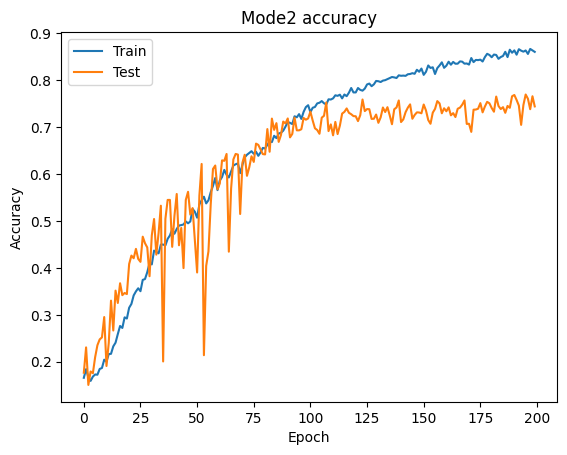

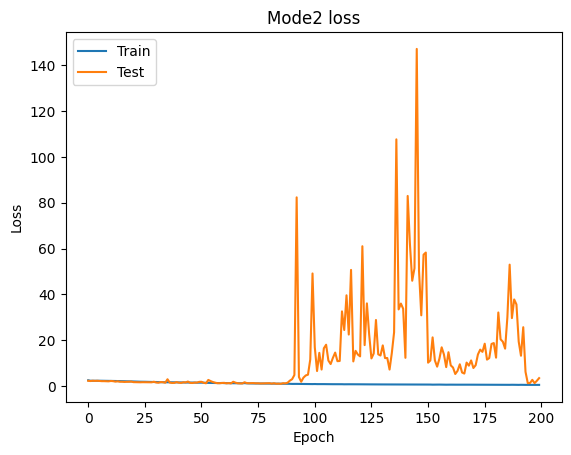

              precision    recall  f1-score   support

           0       0.09      0.09      0.09       102
           1       0.12      0.12      0.12       112
           2       0.12      0.12      0.12        99
           3       0.11      0.12      0.12        92
           4       0.10      0.10      0.10        99
           5       0.08      0.08      0.08        85
           6       0.13      0.11      0.12       107
           7       0.07      0.07      0.07       102
           8       0.11      0.11      0.11        99
           9       0.06      0.07      0.07       103

    accuracy                           0.10      1000
   macro avg       0.10      0.10      0.10      1000
weighted avg       0.10      0.10      0.10      1000



In [17]:
#model2-eval
n_test = 1000
test_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")[:1000]
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    # img_fn = f'../data/test_images/test{i+1:05d}.png'
    img_fn = f'../data/images/{i + 1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(model_II, test_labels, test_imgs)

In [19]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 1000
test_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")[:1000]
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    # img_fn = f'../data/test_images/test{i+1:05d}.png'
    img_fn = f'../data/images/{i + 1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.32      0.45      0.37       102
           1       0.18      0.25      0.21       112
           2       0.24      0.05      0.08        99
           3       0.23      0.15      0.18        92
           4       0.26      0.52      0.34        99
           5       0.18      0.12      0.14        85
           6       0.28      0.36      0.31       107
           7       0.55      0.06      0.11       102
           8       0.27      0.44      0.34        99
           9       0.23      0.12      0.15       103

    accuracy                           0.25      1000
   macro avg       0.27      0.25      0.22      1000
weighted avg       0.27      0.25      0.23      1000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.